https://doc.sagemath.org/html/en/reference/rings_numerical/sage/rings/real_mpfi.html

https://doc.sagemath.org/html/en/reference/spkg/mpfi.html#spkg-mpfi

https://doc.sagemath.org/html/en/reference/spkg/mpfr.html#spkg-mpfr

In [8]:
prec = 200
RBF = RealBallField(prec)
RIF = RealIntervalField(prec)

I = RIF(-1,1)
J=RBF(-1,1)


def g(x):
    return exp(x)


print(abs(g(I).upper()))
print(abs(g(J).upper()))

2.7182818284590452353602874713526624977572470936999595749670
1.0000000065192580223083496093750000000000000000000000000000


In [ ]:
f.taylor(x,2,1)

x |--> 1

{'xmin': -4.0, 'xmax': 2.0, 'ymin': -0.9999942254823972, 'ymax': 0.5061192578887295}


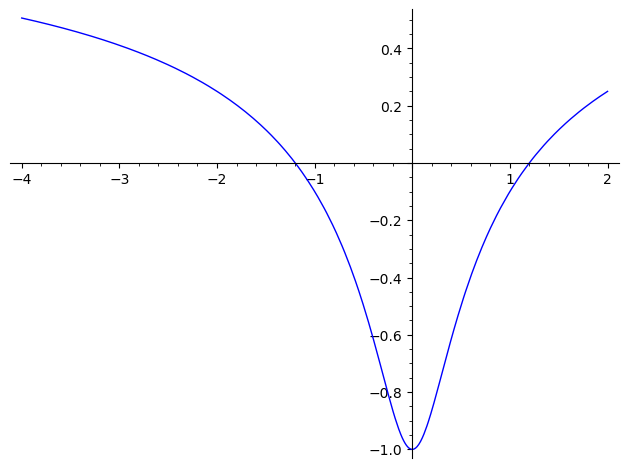

In [8]:
var('x y')

W = (-x/2 + sqrt(1/27 + x^2/4))^(1/3) - (x/2 + sqrt(1/27 + x^2/4))^(1/3)
W_prime = diff(W, x)
a = 1 + W/x + W_prime

P= plot(a, (x, -4, 2))
print(P.get_minmax_data())
P.show()

In [ ]:
def maximum_interval(f, a, b, prec=100):
    """
    Calcule une majoration du maximum absolu de f sur l'intervalle [a, b]
    en utilisant l'arithmétique des intervalles (RealIntervalField).
    
    Paramètres :
    - f : une fonction Sage avec une variable nommée x
    - a, b : bornes réelles de l'intervalle [a, b]
    - prec : précision (en bits) de l'arithmétique des intervalles

    Retour :
    - Une borne supérieure de |f(x)| sur [a, b]
    """
    RIF = RealIntervalField(prec)
    x = var('x')
    I = RIF(a, b)
    
    fxI = f(x=I)
    upper = abs(RIF(fxI)).upper()
    lower = abs(RIF(fxI)).lower()
    
    return max(upper, lower)

x = var('x')
f = lambda x: sin(x) + x^2
maximum_interval(phi_1, 2, 3)

In [ ]:
phi_1_d1_0=diff(phi_list[1],x).taylor(x,0)
phi_1_d1_func=smooth_fast_callable(diff(phi_list[1],x),x,phi_1_d1_0)

phi_1_d2_0=diff(diff(phi_list[2],x),x).taylor(x,0)
phi_1_d1_func=smooth_fast_callable(diff(diff(phi_list[2],x),x),x,phi_1_d2_0)


def M_0_func(ball1,ball2):
    M_fast = fast_callable(M_0, vars=[x,y], domain=RBF)
    if ball1==ball2 :
        return (lambda_list_0[0] * phi_funcs[0](ball2))
    if ball2==RBF(0):
        return (lambda_funcs[0](ball1-ball2) * phi_list_0[0])
    else :
        return M_fast(ball1,ball2)
    
M_1 = (lambda_list[1](x=x - y) * diff(phi_list[1], x)(x=y) + lambda_list[2](x=x - y) * phi_list[1](x=y))

def M_1_func(ball1, ball2):
    M_fast = fast_callable(M_1, vars=[x,y], domain=RBF)
    if ball1 == ball2:
        return lambda_list_0[1] * diff(phi_list[0], x)(x=ball2) + lambda_list_0[2] * phi_list_0[1]
    if ball2 == RBF(0):
        # cas ball2 == 0
        return lambda_list[1](ball1 - ball2) * diff(phi_list[0], x)(x=ball2) + lambda_list[2](ball1 - ball2) * phi_list_0[1]
    else:
        return M_fast(ball1, ball2)


def M_2_func(ball1, ball2):
    M_fast = fast_callable(M_2, vars=[x,y], domain=RBF)
    if ball1 == ball2:
        # cas ball1 == ball2, valeurs en 0
        return lambda_list_0[3] * diff(diff(phi_list[2], x), x)(x=ball2) + lambda_list_0[3] * diff(phi_list[2], x)(x=ball2) + lambda_list_0[4] * phi_list_0[2]
    if ball2 == RBF(0):
        # cas ball2 == 0
        return (lambda_list[3](ball1 - ball2) * diff(diff(phi_list[2], x), x)(x=ball2) +
                lambda_list[3](ball1 - ball2) * diff(phi_list[2], x)(x=ball2) +
                lambda_list[4](ball1 - ball2) * phi_list_0[2])
    else:
        return M_fast(ball1, ball2)




#M_funcs=[smooth_convert_2D_safe(expr,x,y) for expr in M_list]

In [9]:
f(x)=exp(-x^2)
g(x)=sin(x)
phi(x,y)=f(x=x-y)*g(x=y)

plot3d(phi,(x,-5,5),(y,-5,5))

Graphics3d Object